# Load dependencies
- Change oversample indices

In [1]:
# !pip install tabulate
# !pip install keras_applications
# !pip install classification-models-3D

In [2]:
import os
import h5py
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
# from PIL import Image
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
# from scipy import ndimage
from scipy import ndimage
from scipy.special import expit, logit

from skimage import exposure
import sklearn.metrics as skm
from tabulate import tabulate

# Tensorflow/Keras
import tensorflow as tf
print(tf.__version__)
from tensorflow import keras
from keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from keras.utils import to_categorical
# from tensorflow.keras.applications.imagenet_utils import preprocess_input

# Own functions
from functions.plot_slices import plot_slices
# ontram functions
from k_ontram_functions.ontram import ontram
from k_ontram_functions.ontram_loss import ontram_loss
from k_ontram_functions.ontram_metrics import ontram_acc, ontram_auc
from k_ontram_functions.ontram_predict import predict_ontram, get_parameters

from functions.augmentation3d import zoom, rotate, flip, shift

2.4.0


In [3]:
# Define the path + output path:
# os.getcwd()
DIR = "/tf/notebooks/"
DATA_DIR = "/tf/notebooks/hezo/stroke_zurich/data/"
IMG_DIR = "/tf/notebooks/hezo/stroke_zurich/data/" #"/kook/usz-data-10fold/"
OUTPUT_DIR = "/tf/notebooks/hezo/stroke_zurich/callbacks/3D_CNN_ONTRAM_Zurich_DWI_mrs_preprocessed_ENSEMBLE_CV_ORDINAL_Resnet/"

# Import images

In [4]:
with h5py.File(IMG_DIR + 'dicom_2d_192x192x3_clean_interpolated_18_02_2021_preprocessed2.h5', "r") as h5:
    X_in = h5["X"][:]
    Y_img = h5["Y_img"][:]
    Y_pat = h5["Y_pat"][:]
    pat = h5["pat"][:]
print(X_in.shape, X_in.min(), X_in.max(), X_in.mean(), X_in.std())

(439, 128, 128, 28) -0.7314910890799393 26.423200798592248 -4.100563400421584e-18 1.0


In [5]:
X_in = np.expand_dims(X_in, axis=4)
print(X_in.shape, X_in.min(), X_in.max(), X_in.mean(), X_in.std())

(439, 128, 128, 28, 1) -0.7314910890799393 26.423200798592248 -4.100563400421584e-18 1.0


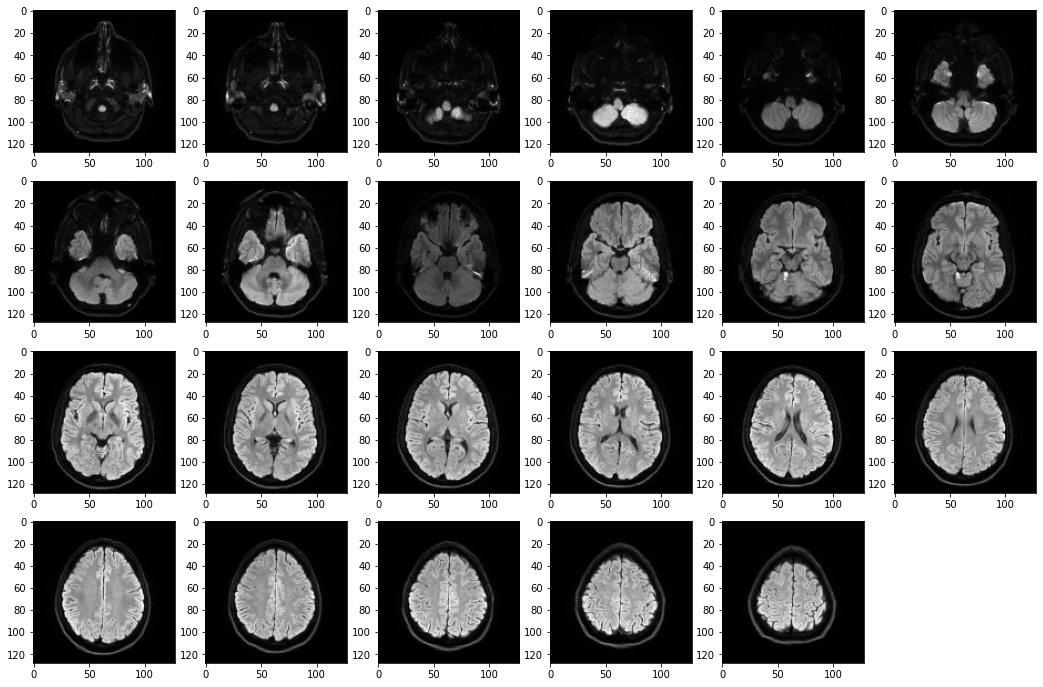

In [6]:
plot_slices(X_in[0], 0, "axial", modality = "DWI")

#### Adapt image size for ResNet

In [ ]:
# Reshape the data to the correct dimension
dim = (128, 128, 20, 1)
xdim, ydim, zdim, cdim = X_in[0].shape

X_in_res = np.empty((len(X_in), 128, 128, 20, 3))
for i in range(len(X_in)):
    scaling_factor = [dim[0]/xdim, dim[1]/ydim, dim[2]/zdim, dim[3]/cdim]
    X_in_res[i,:,:,:,:] = ndimage.zoom(X_in[i], scaling_factor, order = 1)
X_in_res[:,:,:,:,1] = X_in_res[:,:,:,:,0]
X_in_res[:,:,:,:,2] = X_in_res[:,:,:,:,0]

del X_in
plot_slices(X_in_res[0], 0, "axial", "DWI")

# Import clinical and patient data

In [ ]:
dat = pd.read_csv(DATA_DIR + 'baseline_data_zurich_prepared0.csv', sep = ";")
dat

In [ ]:
dat[dat.p_id == 1]

In [ ]:
dat = dat.replace(to_replace=r',', value='.', regex=True)

In [ ]:
# Size of the dataframe: same as the images
dat.shape

In [ ]:
# NAs?
[dat.age.isnull().sum(), 
 dat.sexm.isnull().sum(), 
 dat.nihss_baseline.isnull().sum(),  
 dat.mrs_before.isnull().sum(), 
 dat.stroke_beforey.isnull().sum(), 
 dat.tia_beforey.isnull().sum(), 
 dat.rf_hypertoniay.isnull().sum(),
 dat.rf_diabetesy.isnull().sum(), 
 dat.rf_hypercholesterolemiay.isnull().sum(),
 dat.rf_smokery.isnull().sum(), 
 dat.rf_atrial_fibrillationy.isnull().sum(), 
 dat.rf_chdy.isnull().sum()]

In [ ]:
# # simple imputation: replace all missing values with the mode of the column
for column in dat.columns:
    dat[column].fillna(dat[column].mode()[0], inplace=True)

In [ ]:
n = []
for p in pat:
    if p in dat.p_id.values:
        n.append(p)
#n
n = len(n)

In [ ]:
# Match image and tabular data
X = np.zeros((n, X_in_res.shape[1], X_in_res.shape[2], X_in_res.shape[3], X_in_res.shape[4]))
X_tab = np.zeros((n, 13))
Y_mrs = np.zeros((n))
Y_eventtia = np.zeros((n))
p_id = np.zeros((n))

i = 0
for j, p in enumerate(pat):
    if p in dat.p_id.values:
        k = np.where(dat.p_id.values == p)[0]
        X_tab[i,:] = dat.loc[k,["age", "sexm", "nihss_baseline", "mrs_before",
                               "stroke_beforey", "tia_beforey", "ich_beforey", 
                               "rf_hypertoniay", "rf_diabetesy", "rf_hypercholesterolemiay", 
                               "rf_smokery", "rf_atrial_fibrillationy", "rf_chdy"]]
        X[i] = X_in_res[j]
        p_id[i] = pat[j]
        Y_eventtia[i] = Y_pat[j]
        Y_mrs[i] = dat.loc[k, "mrs3"]
        i += 1
del X_in_res
X_tab.shape


In [ ]:
# Zuordnung passt:
#X_tab[0]
#plot_slices(X[0], 0, "axial", "DWI")

#### Train, validation and test

In [ ]:
Y = np.array(Y_mrs)
print(Y.shape)
Y = to_categorical(Y)
print(Y.shape)

# Define models

In [ ]:
# Model for the intercept function: C = number of classes
def mod_baseline(C):
    mod = keras.Sequential(name = "mod_baseline")
    mod.add(keras.Input(shape = (1, )))
    mod.add(keras.layers.Dense(C - 1, activation = "linear", use_bias = False))
    return mod

# Model for linear shift terms
def mod_linear_shift(x):
    mod = keras.Sequential(name = "mod_linear_shift")
    mod.add(keras.Input(shape = (x, )))
    mod.add(keras.layers.Dense(1, activation = "linear", use_bias = False))
    return mod

# Model for complex shift terms
def mod_complex_shift(x):
    mod = keras.Sequential(name = "mod_complex_shift")
    mod.add(keras.Input(shape = (x, )))
    mod.add(keras.layers.Dense(8, activation = "relu"))
    mod.add(keras.layers.Dense(8, activation = "relu"))
    mod.add(keras.layers.Dense(1, activation = "linear", use_bias = False))
    return mod  

In [ ]:
from classification_models_3D_master.classification_models_3D_master.classification_models_3D.tfkeras import Classifiers

In [ ]:
# ResNet with pretrained weights
# Problems with github repo after update: downloaded the repo and adapted manually
#from classification_models_3D.tfkeras import Classifiers

def img_model(nout, last_layer_activation = "linear"):
    ResNet50, preprocess_input = Classifiers.get('resnet50')
    base_model = ResNet50(
        input_shape=(128, 128, 20, 3), 
        weights='imagenet', 
        include_top = False)

    # add a global average pooling layer and the dense part and define model
    x = base_model.output
    x = keras.layers.GlobalAveragePooling3D()(x)
    x = keras.layers.Dense(128, name="fc1")(x)
    x = keras.layers.Dense(128, name = "fc2")(x)
    x = keras.layers.Dense(nout, name="output")(x)
    predictions = keras.layers.Activation(last_layer_activation, name='output_activation')(x)
    
    return keras.Model(inputs=base_model.input, outputs=predictions)
mod = img_model(1, "linear")
mod.summary()

# ONTRAMs

In [ ]:
# Hyperparameters for all models
C = 7

### Simple intercept, linear shift (POLR)
Covariates defined by Susanne (without image parameters!)

In [ ]:
folder_name = "SI_LSx/"

# # create folders: run only once
# os.mkdir(OUTPUT_DIR + folder_name)
# for i in range(5):
#     os.mkdir(OUTPUT_DIR + folder_name + "fold" + str(i))
#     for j in range(5):
#         os.mkdir(OUTPUT_DIR + folder_name + "fold" + str(i) + "/run" + str(j))

In [ ]:
# Hyperparameters
batch_size = 128
epochs = 10000

In [ ]:
# Implement 5 fold CV:
# kf = KFold(n_splits=5, shuffle = True, random_state = 100)
# for train, test in kf.split(X_tab):
#     train, valid = train_test_split(train, test_size = 60, random_state = 100)
#     print((train, valid, test, len(train), len(valid), len(test)))

In [ ]:
# 13 variables:
# X_tab.shape

In [ ]:
j = 0
my_seed = 1

n_int = 6 # number intercepts = number of classes -1
n_var = 13 #number variables
nll = np.empty((5, 1))
estimates = np.empty((5, n_int + n_var)) # intercepts + variables
estimates_sd = np.empty((5, n_int + n_var)) 

kf = KFold(n_splits=5, shuffle = True, random_state = 100)

for train_idx, test_idx in kf.split(X_tab):
    
    # split train into train and validation index
    train_idx, valid_idx = train_test_split(train_idx, test_size = 60, random_state = 100)
    
    
    # Load data for fold j ------------------------------------------------------
    
    # define datasets
    X_tab_train = X_tab[train_idx]
    X_tab_valid = X_tab[valid_idx]
    X_tab_test = X_tab[test_idx]
    
    # normalize
    sd = np.empty((n_var,))
    for i in range(X_tab_train.shape[1]):
        train_mean = np.mean(X_tab_train[:,i])
        train_std = np.std(X_tab_train[:,i])
        X_tab_train[:,i] = (X_tab_train[:,i] - train_mean) / train_std
        X_tab_valid[:,i] = (X_tab_valid[:,i] - train_mean) / train_std
        X_tab_test[:,i] = (X_tab_test[:,i] - train_mean) / train_std
        sd[i] = train_std
    
    Y_train = Y[train_idx]
    Y_valid = Y[valid_idx]
    Y_test = Y[test_idx]
    
    
    # Define datasets for ONTRAM ------------------------------------------------------
    
    train_data = tf.data.Dataset.from_tensor_slices((np.ones(shape=[len(X_tab_train),1]), X_tab_train))
    train_labels = tf.data.Dataset.from_tensor_slices((Y_train))
    
    valid_data = tf.data.Dataset.from_tensor_slices((np.ones(shape=[len(X_tab_valid),1]), X_tab_valid))
    valid_labels = tf.data.Dataset.from_tensor_slices((Y_valid))

    test_data = tf.data.Dataset.from_tensor_slices((np.ones(shape=[len(X_tab_test),1]), X_tab_test))
    test_labels = tf.data.Dataset.from_tensor_slices((Y_test))
    
    train_loader = tf.data.Dataset.zip((train_data, train_labels))
    validation_loader = tf.data.Dataset.zip((valid_data, valid_labels))
    test_loader = tf.data.Dataset.zip((test_data, test_labels))
    
    train_dataset = (train_loader.shuffle(len(X_tab_train)).batch(batch_size, drop_remainder=True))
    validation_dataset = (validation_loader.batch(batch_size, drop_remainder=True))
    test_dataset = (test_loader.batch(len(X_tab_test)))
    
    
    # Training ---------------------------------------------------------------------
    
    # Train 5 ensembles
    for i in range(5):
        
        # define model
        mbl = mod_baseline(Y_train.shape[1])
        mls = mod_linear_shift(X_tab_train.shape[1])
        model = ontram(mbl, mls)
        
        # save final model
        checkpoint_filepath = OUTPUT_DIR + folder_name + "fold" + str(j) + "/" + "run" + str(i) + "/"
        
        # compile and train
        model.compile(optimizer = keras.optimizers.Adam(),
                      loss = ontram_loss(C, batch_size),
                      metrics = [ontram_acc(C, batch_size)])
        
        history = model.fit(train_dataset,
                            validation_data = validation_dataset,
                            epochs = epochs,
                            shuffle = True)
        
        pd.DataFrame(history.history).to_csv(checkpoint_filepath + "history.csv", index = False)
        model.save_weights(checkpoint_filepath + "model_weights.hdf5")
        
        # Do predictions
        test_batch_size = len(X_tab_test)
        model.compile(loss = ontram_loss(C, test_batch_size))
        preds = predict_ontram(model, data = test_dataset)
        params = get_parameters(model)
        
        # save predictions/parameters
        cdf = pd.DataFrame(preds["cdf"])
        cdf.columns = ["y_pred" + str(i) for i in range(n_int+2)]
        cdf["p_id"] = p_id[test_idx]
        cdf["y_true"] = np.argmax(Y_test, axis=1)
        cdf.to_csv(checkpoint_filepath + "cdf.csv", index = False)  
        
        pdf = pd.DataFrame(preds["pdf"])
        pdf.columns = ["y_pred" + str(i) for i in range(n_int+1)]
        pdf["p_id"] = p_id[test_idx]
        pdf["y_true"] = np.argmax(Y_test, axis=1)
        pdf.to_csv(checkpoint_filepath + "pdf.csv", index = False)
        
        nll[i] = preds["nll"]
        estimates[i] = np.concatenate((params["intercept"][0][0][0], np.concatenate(params["shift"][0][0][0]))) 
        estimates_sd[i] = np.concatenate((params["intercept"][0][0][0], np.concatenate(params["shift"][0][0][0])/sd)) 
    
    pd.DataFrame(nll).to_csv(OUTPUT_DIR + folder_name + "/fold" + str(j) + "/nll.csv", index = False)
    
    pd_estimates = pd.DataFrame(estimates)
    pd_estimates.columns = ["intercept0", "intercept1", "intercept2", "intercept3", "intercept4", 
                            "intercept5", "age", "sexm", "nihss_baseline", "mrs_before",
                            "stroke_beforey", "tia_beforey", "ich_beforey", 
                            "rf_hypertoniay", "rf_diabetesy", "rf_hypercholesterolemiay", 
                            "rf_smokery", "rf_atrial_fibrillationy", "rf_chdy"]
    pd_estimates.to_csv(OUTPUT_DIR + folder_name + "/fold" + str(j) + "/estimates.csv", index = False)
    pd_estimates_sd = pd.DataFrame(estimates_sd)
    pd_estimates_sd.columns = ["intercept0", "intercept1", "intercept2", "intercept3", "intercept4", 
                               "intercept5", "age", "sexm", "nihss_baseline", "mrs_before",
                               "stroke_beforey", "tia_beforey", "ich_beforey", 
                               "rf_hypertoniay", "rf_diabetesy", "rf_hypercholesterolemiay", 
                               "rf_smokery", "rf_atrial_fibrillationy", "rf_chdy"]
    pd_estimates_sd.to_csv(OUTPUT_DIR + folder_name + "/fold" + str(j) + "/estimates_sd.csv", index = False)
    
    j += 1

### Simple Intercept, Complex Shift

In [ ]:
folder_name = "SI_CSb/"

# # create folders: run only once
# os.mkdir(OUTPUT_DIR + folder_name)
# for i in range(5):
#     os.mkdir(OUTPUT_DIR + folder_name + "fold" + str(i))
#     for j in range(5):
#         os.mkdir(OUTPUT_DIR + folder_name + "fold" + str(i) + "/run" + str(j))

In [ ]:
# Hyperparameters
batch_size = 8
toplayer_epochs = 40
alllayer_epochs = 100

In [ ]:
# depends on the model
def train_preprocessing(data, label):
    """Process training data."""
    intercept = data[0] # intercept
    volume = data[1] # shift: image
    volume = zoom(volume)
    volume = rotate(volume)
    volume = shift(volume)
    volume = flip(volume)
    return (intercept, volume), label

In [ ]:
j = 0
my_seed = 1
nll = np.empty((5, 1))

n_int = 6 # number intercepts = number of classes -1
nll = np.empty((5, 1))

kf = KFold(n_splits=5, shuffle = True, random_state = 100)

for train_idx, test_idx in kf.split(X_tab):
    
    # split train into train and validation index
    train_idx, valid_idx = train_test_split(train_idx, test_size = 60, random_state = 100)
    
    # Load data for fold j ------------------------------------------------------
     
    X_train = X[train_idx]
    X_valid = X[valid_idx]
    X_test = X[test_idx]
    
    Y_train = Y[train_idx]
    Y_valid = Y[valid_idx]
    Y_test = Y[test_idx]
    
        
    # Define datasets for ONTRAM ------------------------------------------------------

    train_data = tf.data.Dataset.from_tensor_slices((np.ones(shape=[len(X_train),1]), X_train))
    train_labels = tf.data.Dataset.from_tensor_slices((Y_train))
    
    valid_data = tf.data.Dataset.from_tensor_slices((np.ones(shape=[len(X_valid),1]), X_valid))
    valid_labels = tf.data.Dataset.from_tensor_slices((Y_valid))
    
    test_data = tf.data.Dataset.from_tensor_slices((np.ones(shape=[len(X_test),1]), X_test))
    test_labels = tf.data.Dataset.from_tensor_slices((Y_test))
    
    train_loader = tf.data.Dataset.zip((train_data, train_labels))
    validation_loader = tf.data.Dataset.zip((valid_data, valid_labels))
    test_loader = tf.data.Dataset.zip((test_data, test_labels))
    
    train_dataset = (train_loader.shuffle(len(X_train))
                     .map(train_preprocessing)
                     .batch(batch_size, drop_remainder = True))
    validation_dataset = (validation_loader.batch(batch_size, drop_remainder = True))
    test_dataset = (test_loader.batch(len(X_test)))
    
    
    # Training ---------------------------------------------------------------------
    
    # Train 5 ensembles
    for i in range(5):
        
        # Define model
        mbl = mod_baseline(C)
        mcs = img_model(1, "linear")
        
        # start to train the top layers
        for layer in mcs.layers:
            layer.trainable = False
        model = ontram(mbl, mcs)
        
        # save weights of the best model
        checkpoint_filepath = OUTPUT_DIR + folder_name + "/fold" + str(j) + "/" + "run" + str(i) + "/"
        model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath = checkpoint_filepath,
                                                                       save_weights_only = True,
                                                                       monitor = "val_loss",
                                                                       mode = "min",
                                                                       save_best_only = True)
        
        # compile and train
        model.compile(optimizer = keras.optimizers.Adam(),
                    loss = ontram_loss(C, batch_size),
                    metrics = [ontram_acc(C, batch_size)])
        history_0 = model.fit(train_dataset,
                              validation_data = validation_dataset,
                              epochs = toplayer_epochs,
                              shuffle = True,
                              verbose = 2,
                              callbacks=[model_checkpoint_callback])
        
        # Load the wieghts and unfreeze the layers
        model.load_weights(checkpoint_filepath)
        for layer in model.layers:
            layer.trainable = True
        
        # recompile the model for the modifications to take effect
        model.compile(optimizer = keras.optimizers.Adam(lr=0.0001), 
                      loss = ontram_loss(C, batch_size),
                      metrics = [ontram_acc(C, batch_size)])   
        history_1 = model.fit(train_dataset,
                              validation_data = validation_dataset,
                              epochs = alllayer_epochs,
                              shuffle = True,
                              verbose = 2,
                              callbacks=[model_checkpoint_callback])
        
        # save the history
        pd.DataFrame(history_0.history).append(pd.DataFrame(history_1.history)).to_csv(checkpoint_filepath + "history.csv", index = False)
        
        # Do predictions
        model.load_weights(checkpoint_filepath)
        test_batch_size = len(X_test)
        model.compile(loss = ontram_loss(C, test_batch_size))
        preds = predict_ontram(model, data = test_dataset)
        
        # save predictions/parameters
        cdf = pd.DataFrame(preds["cdf"])
        cdf.columns = ["y_pred" + str(i) for i in range(n_int+2)]
        cdf["p_id"] = p_id[test_idx]
        cdf["y_true"] = np.argmax(Y_test, axis=1)
        cdf.to_csv(checkpoint_filepath + "cdf.csv", index = False) 
        
        pdf = pd.DataFrame(preds["pdf"])
        pdf.columns = ["y_pred" + str(i) for i in range(n_int+1)]
        pdf["p_id"] = p_id[test_idx]
        pdf["y_true"] = np.argmax(Y_test, axis=1)
        pdf.to_csv(checkpoint_filepath + "pdf.csv", index = False)
        
        nll[i] = preds["nll"]
    
    pd.DataFrame(nll).to_csv(OUTPUT_DIR + folder_name + "/fold" + str(j) + "/nll.csv", index = False)
    
    j += 1

### Simple intercept, Complex shift, Linear shift

In [ ]:
folder_name = "SI_LSx_CSb/"
POLR_DIR = OUTPUT_DIR + "SI_LSx/"

## create folders: run only once
#os.mkdir(OUTPUT_DIR + folder_name)
#for i in range(5):
#    os.mkdir(OUTPUT_DIR + folder_name + "fold" + str(i))
#    for j in range(5):
#        os.mkdir(OUTPUT_DIR + folder_name + "fold" + str(i) + "/run" + str(j))

In [ ]:
# Hyperparameters
batch_size = 8
toplayer_epochs = 40
alllayer_epochs = 100

In [ ]:
# function for preprocessing
def train_preprocessing(data, label):
    """Process training data."""
    intercept = data[0] # intercept
    volume = data[1] # shift: image
    tabular = data[2] # shift: tabular
    volume = zoom(volume)
    volume = rotate(volume)
    volume = shift(volume)
    volume = flip(volume)
    return (intercept, volume, tabular), label

In [ ]:
j = 0
my_seed = 1

n_int = 6 # number intercepts = number of classes -1
n_var = 13 #number variables
nll = np.empty((5, 1))
estimates = np.empty((5, n_int + n_var)) # intercepts + variables
estimates_sd = np.empty((5, n_int + n_var)) 

kf = KFold(n_splits=5, shuffle = True, random_state = 100)

for train_idx, test_idx in kf.split(X_tab):
    
    # split train into train and validation index
    train_idx, valid_idx = train_test_split(train_idx, test_size = 60, random_state = 100)
    
    
    # Load data for fold j ------------------------------------------------------
    
    # define datasets
    X_tab_train = X_tab[train_idx]
    X_tab_valid = X_tab[valid_idx]
    X_tab_test = X_tab[test_idx]
    
    # normalize
    sd = np.empty((n_var,))
    for i in range(X_tab_train.shape[1]):
        train_mean = np.mean(X_tab_train[:,i])
        train_std = np.std(X_tab_train[:,i])
        X_tab_train[:,i] = (X_tab_train[:,i] - train_mean) / train_std
        X_tab_valid[:,i] = (X_tab_valid[:,i] - train_mean) / train_std
        X_tab_test[:,i] = (X_tab_test[:,i] - train_mean) / train_std
        sd[i] = train_std
    
    X_train = X[train_idx]
    X_valid = X[valid_idx]
    X_test = X[test_idx]
    
    Y_train = Y[train_idx]
    Y_valid = Y[valid_idx]
    Y_test = Y[test_idx]
    
    
    # Define datasets for ONTRAM ------------------------------------------------------
    
    train_data = tf.data.Dataset.from_tensor_slices((np.ones(shape=[len(X_train),1]), X_train, X_tab_train))
    train_labels = tf.data.Dataset.from_tensor_slices((Y_train))
    
    valid_data = tf.data.Dataset.from_tensor_slices((np.ones(shape=[len(X_valid),1]), X_valid, X_tab_valid))
    valid_labels = tf.data.Dataset.from_tensor_slices((Y_valid))
    
    test_data = tf.data.Dataset.from_tensor_slices((np.ones(shape=[len(X_test),1]), X_test, X_tab_test))
    test_labels = tf.data.Dataset.from_tensor_slices((Y_test))
    
    train_loader = tf.data.Dataset.zip((train_data, train_labels))
    validation_loader = tf.data.Dataset.zip((valid_data, valid_labels))
    test_loader = tf.data.Dataset.zip((test_data, test_labels))
    
    train_dataset = (train_loader.shuffle(len(X_train))
                     .map(train_preprocessing)
                     .batch(batch_size, drop_remainder = True))
    validation_dataset = (validation_loader.batch(batch_size, drop_remainder = True))
    test_dataset = (test_loader.batch(len(X_test), drop_remainder = True))

    # Training ---------------------------------------------------------------------
    
    # Train 5 ensembles
    for i in range(5):
        
        # folder to save weights 

        # define model and load weights from SI_LSx
        mbl = mod_baseline(C)
        mls = mod_linear_shift(X_tab_train.shape[1])
        polr = ontram(mbl, mls)
        polr.load_weights(POLR_DIR + "fold" + str(j) + "/run" + str(i) + "/model_weights.hdf5")
        mcs = img_model(1, "linear")
        
        # start to train the top layers
        for layer in mcs.layers:
            layer.trainable = False
        model = ontram(polr.mod_baseline, [mcs, polr.mod_shift[0]])
        
        # save weights of the best model
        checkpoint_filepath = OUTPUT_DIR + folder_name + "/fold" + str(j) + "/" + "run" + str(i) + "/"
        model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath = checkpoint_filepath,
                                                                       save_weights_only = True,
                                                                       monitor = "val_loss",
                                                                       mode = "min",
                                                                       save_best_only = True)
        
        # compile and train
        model.compile(optimizer = keras.optimizers.Adam(),
                    loss = ontram_loss(C, batch_size),
                    metrics = [ontram_acc(C, batch_size)])
        history_0 = model.fit(train_dataset,
                              validation_data = validation_dataset,
                              epochs = toplayer_epochs,
                              shuffle = True,
                              verbose = 2,
                              callbacks=[model_checkpoint_callback])
        
        # Load the wieghts and unfreeze the layers
        model.load_weights(checkpoint_filepath)
        for layer in model.layers:
            layer.trainable = True
        
        # recompile the model for the modifications to take effect
        model.compile(optimizer = keras.optimizers.Adam(lr=0.0001), 
                      loss = ontram_loss(C, batch_size),
                      metrics = [ontram_acc(C, batch_size)])   
        history_1 = model.fit(train_dataset,
                              validation_data = validation_dataset,
                              epochs = alllayer_epochs,
                              shuffle = True,
                              verbose = 2,
                              callbacks=[model_checkpoint_callback])
        
        # save the history
        pd.DataFrame(history_0.history).append(pd.DataFrame(history_1.history)).to_csv(checkpoint_filepath + "history.csv", index = False)
        
        # Do predictions
        model.load_weights(checkpoint_filepath)
        test_batch_size = len(X_test)
        model.compile(loss = ontram_loss(C, test_batch_size))
        preds = predict_ontram(model, data = test_dataset)
        params = get_parameters(model)
        
        # save predictions/parameters
        cdf = pd.DataFrame(preds["cdf"])
        cdf.columns = ["y_pred" + str(i) for i in range(n_int+2)]
        cdf["p_id"] = p_id[test_idx]
        cdf["y_true"] = np.argmax(Y_test, axis=1)
        cdf.to_csv(checkpoint_filepath + "cdf.csv", index = False)  
        
        pdf = pd.DataFrame(preds["pdf"])
        pdf.columns = ["y_pred" + str(i) for i in range(n_int+1)]
        pdf["p_id"] = p_id[test_idx]
        pdf["y_true"] = np.argmax(Y_test, axis=1)
        pdf.to_csv(checkpoint_filepath + "pdf.csv", index = False)
        
        nll[i] = preds["nll"]
        estimates[i] = np.concatenate((params["intercept"][0][0][0], np.concatenate(params["shift"][0][1][0]))) 
        estimates_sd[i] = np.concatenate((params["intercept"][0][0][0], np.concatenate(params["shift"][0][1][0])/sd)) 
    
    pd.DataFrame(nll).to_csv(OUTPUT_DIR + folder_name + "/fold" + str(j) + "/nll.csv", index = False)
    
    pd_estimates = pd.DataFrame(estimates)
    pd_estimates.columns = ["intercept0", "intercept1", "intercept2", "intercept3", "intercept4", 
                            "intercept5", "age", "sexm", "nihss_baseline", "mrs_before",
                            "stroke_beforey", "tia_beforey", "ich_beforey", 
                            "rf_hypertoniay", "rf_diabetesy", "rf_hypercholesterolemiay", 
                            "rf_smokery", "rf_atrial_fibrillationy", "rf_chdy"]
    pd_estimates.to_csv(OUTPUT_DIR + folder_name + "/fold" + str(j) + "/estimates.csv", index = False)
    
    pd_estimates_sd = pd.DataFrame(estimates_sd)
    pd_estimates_sd.columns = ["intercept0", "intercept1", "intercept2", "intercept3", "intercept4", 
                               "intercept5", "age", "sexm", "nihss_baseline", "mrs_before",
                               "stroke_beforey", "tia_beforey", "ich_beforey", 
                               "rf_hypertoniay", "rf_diabetesy", "rf_hypercholesterolemiay", 
                               "rf_smokery", "rf_atrial_fibrillationy", "rf_chdy"]
    pd_estimates_sd.to_csv(OUTPUT_DIR + folder_name + "/fold" + str(j) + "/estimates_sd.csv", index = False)
    
    j += 1

# Trafo ensembles
Calculate the average CDF per patient by averaging the transformation functions

In [43]:
folder_names = ["SI_LSx", "SI_CSb", "SI_LSx_CSb"]

In [ ]:
for folder_name in folder_names:
    for f in range(5): # fold
        checkpoint_filepath = OUTPUT_DIR + folder_name + "/fold" + str(f) + "/"
        cdf0 = pd.read_csv(checkpoint_filepath + "run0/cdf.csv")
        cdf1 = pd.read_csv(checkpoint_filepath + "run1/cdf.csv")
        cdf2 = pd.read_csv(checkpoint_filepath + "run2/cdf.csv")
        cdf3 = pd.read_csv(checkpoint_filepath + "run3/cdf.csv")
        cdf4 = pd.read_csv(checkpoint_filepath + "run4/cdf.csv")
        cdf = pd.concat((cdf0[["y_pred0", "y_pred1", "y_pred2", "y_pred3", "y_pred4", "y_pred5", "y_pred6", "y_pred7"]], 
                         cdf1[["y_pred0", "y_pred1", "y_pred2", "y_pred3", "y_pred4", "y_pred5", "y_pred6", "y_pred7"]], 
                         cdf2[["y_pred0", "y_pred1", "y_pred2", "y_pred3", "y_pred4", "y_pred5", "y_pred6", "y_pred7"]], 
                         cdf3[["y_pred0", "y_pred1", "y_pred2", "y_pred3", "y_pred4", "y_pred5", "y_pred6", "y_pred7"]], 
                         cdf4[["y_pred0", "y_pred1", "y_pred2", "y_pred3", "y_pred4", "y_pred5", "y_pred6", "y_pred7"]]))
        by_row_index = cdf.groupby(cdf.index)
        
        trafo_cdf = by_row_index.apply(lambda x: expit(np.mean(logit(x))))
        trafo_pdf = np.array(trafo_cdf)[:,1:] - np.array(trafo_cdf)[:,:-1]
        y_pred = np.argmax(trafo_pdf, axis = 1)
        y_pred_fav = np.sum(trafo_pdf[:,:3], axis = 1) # mRS 0-2
        y_pred_unfav = np.sum(trafo_pdf[:,3:], axis = 1) # mRS 3-6
        y_pred_bin = np.where(y_pred_fav>0.5, 1, 0)
        y_true_bin = np.where(cdf0.y_true<=2, 1, 0)
        
        trafo_cdf["p_id"] = cdf0.p_id
        trafo_cdf["y_true"] = cdf0.y_true
        trafo_cdf["y_pred"] = y_pred
        trafo_cdf.to_csv(checkpoint_filepath + "/trafo_cdf.csv", index = False)
        
        trafo_pdf = pd.DataFrame(trafo_pdf)
        trafo_pdf.columns = ["y_pred" + str(i) for i in range(7)]
        trafo_pdf["p_id"] = cdf0.p_id
        trafo_pdf["y_true"] = cdf0.y_true 
        trafo_pdf["y_pred"] = y_pred
        trafo_pdf.to_csv(checkpoint_filepath + "/trafo_pdf.csv", index = False)
        
        trafo_pdf_bin = pd.DataFrame({"y_pred1_fav": y_pred_fav, 
                                      "y_pred0_unfav": y_pred_unfav,
                                      "y_pred": y_pred_bin,
                                      "y_true": y_true_bin,
                                      "p_id": cdf0.p_id})
        trafo_pdf_bin.to_csv(checkpoint_filepath + "/trafo_pdf_bin.csv", index = False)

In [ ]:
# combine all test samples
for folder_name in folder_names:
    checkpoint_filepath = OUTPUT_DIR + folder_name 
    cdf0 = pd.read_csv(checkpoint_filepath + "/fold0/trafo_cdf.csv")
    cdf1 = pd.read_csv(checkpoint_filepath + "/fold1/trafo_cdf.csv")
    cdf2 = pd.read_csv(checkpoint_filepath + "/fold2/trafo_cdf.csv")
    cdf3 = pd.read_csv(checkpoint_filepath + "/fold3/trafo_cdf.csv")
    cdf4 = pd.read_csv(checkpoint_filepath + "/fold4/trafo_cdf.csv")
    cdf = pd.concat((cdf0, cdf1, cdf2, cdf3, cdf4))
    cdf.to_csv(OUTPUT_DIR + folder_name + "/test_cdf.csv", index = False)
    
    pdf0 = pd.read_csv(checkpoint_filepath + "/fold0/trafo_pdf.csv")
    pdf1 = pd.read_csv(checkpoint_filepath + "/fold1/trafo_pdf.csv")
    pdf2 = pd.read_csv(checkpoint_filepath + "/fold2/trafo_pdf.csv")
    pdf3 = pd.read_csv(checkpoint_filepath + "/fold3/trafo_pdf.csv")
    pdf4 = pd.read_csv(checkpoint_filepath + "/fold4/trafo_pdf.csv")
    pdf = pd.concat((pdf0, pdf1, pdf2, pdf3, pdf4))
    pdf.to_csv(OUTPUT_DIR + folder_name + "/test_pdf.csv", index = False)
    
    pdf_bin0 = pd.read_csv(checkpoint_filepath + "/fold0/trafo_pdf_bin.csv")
    pdf_bin1 = pd.read_csv(checkpoint_filepath + "/fold1/trafo_pdf_bin.csv")
    pdf_bin2 = pd.read_csv(checkpoint_filepath + "/fold2/trafo_pdf_bin.csv")
    pdf_bin3 = pd.read_csv(checkpoint_filepath + "/fold3/trafo_pdf_bin.csv")
    pdf_bin4 = pd.read_csv(checkpoint_filepath + "/fold4/trafo_pdf_bin.csv")
    pdf_bin = pd.concat((pdf_bin0, pdf_bin1, pdf_bin2, pdf_bin3, pdf_bin4))
    pdf_bin.to_csv(OUTPUT_DIR + folder_name + "/test_pdf_bin.csv", index = False)

# Results

In [46]:
nll = ["nll"]
acc = ["acc"]
qwk = ["qwk"]
nll_bin = ["nll_bin"]
acc_bin = ["acc_bin"]
bs = ["bs"]
auc = ["auc"]
for folder_name in folder_names:
    pdf = pd.read_csv(OUTPUT_DIR + folder_name + "/test_pdf.csv")
    pdf_bin = pd.read_csv(OUTPUT_DIR + folder_name + "/test_pdf_bin.csv")
    
    nll.append(skm.log_loss(pdf.y_true, pdf[["y_pred0", "y_pred1", "y_pred2", "y_pred3", "y_pred4", "y_pred5", "y_pred6"]]))
    acc.append(skm.accuracy_score(pdf.y_true, pdf.y_pred))
    qwk.append(skm.cohen_kappa_score(pdf.y_true, pdf.y_pred, labels = [0,1,2,3,4,5,6], weights = "quadratic"))
    
    nll_bin.append(skm.log_loss(pdf_bin.y_true, pdf_bin[["y_pred0_unfav","y_pred1_fav"]]))
    acc_bin.append(skm.accuracy_score(pdf_bin.y_true, pdf_bin.y_pred))
    bs.append(skm.brier_score_loss(y_true = pdf_bin.y_true, y_prob = pdf_bin.y_pred1_fav, pos_label = 1))
    auc.append(skm.roc_auc_score(y_true = pdf_bin.y_true, y_score = pdf_bin.y_pred1_fav))

In [47]:
# Ordinal outcome
header = [" ", "SI_LSx", "SI_CSb", "SI_LSx_CSb"]
data = [nll, acc, qwk]
print(tabulate(data, headers = header, tablefmt = "grid"))

+-----+----------+----------+--------------+
|     |   SI_LSx |   SI_CSb |   SI_LSx_CSb |
+=====+==========+==========+==============+
| nll | 1.41925  | 1.46932  |     1.42709  |
+-----+----------+----------+--------------+
| acc | 0.444444 | 0.44686  |     0.44686  |
+-----+----------+----------+--------------+
| qwk | 0.371218 | 0.221314 |     0.441446 |
+-----+----------+----------+--------------+


In [48]:
# Binary outcome
header = [" ", "SI_LSx", "SI_CSb", "SI_LSx_CSb"]
data = [nll_bin, acc_bin, bs, auc]
print(tabulate(data, headers = header, tablefmt = "grid"))

+---------+----------+----------+--------------+
|         |   SI_LSx |   SI_CSb |   SI_LSx_CSb |
+=========+==========+==========+==============+
| nll_bin | 0.373732 | 0.39697  |     0.370543 |
+---------+----------+----------+--------------+
| acc_bin | 0.838164 | 0.826087 |     0.84058  |
+---------+----------+----------+--------------+
| bs      | 0.114528 | 0.12348  |     0.11267  |
+---------+----------+----------+--------------+
| auc     | 0.809867 | 0.796131 |     0.816239 |
+---------+----------+----------+--------------+


In [49]:
# Estimates
folder_names = ["SI_LSx", "SI_LSx_CSb"]
model_est = []
for folder_name in folder_names:
    cv_est = []
    for f in range(5):
        checkpoint_filepath = OUTPUT_DIR + folder_name + "/fold" + str(f) + "/"
        est = pd.read_csv(checkpoint_filepath + "estimates.csv")
        cv_est.append(est)
    cv_est = pd.concat(cv_est)
    model_est.append(cv_est)

In [52]:
estimates = pd.concat([pd.DataFrame(model_est[0].mean()), pd.DataFrame(model_est[1].mean())], axis = 1)
estimates.columns = folder_names
estimates

,SI_LSx,SI_LSx_CSb
intercept0,-0.336453,-0.385206
intercept1,0.092652,0.102530
intercept2,0.098020,0.112410
intercept3,-0.432864,-0.424157
intercept4,-0.267550,-0.259609
intercept5,-1.467402,-1.468169
age,0.003020,-0.006389
sexm,0.000459,0.002505
nihss_baseline,0.876494,0.866474
mrs_before,0.459435,0.454372
